In [38]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline

# Definisi fungsi crop_and_resize
def crop_and_resize(image, target_w, target_h):
    h, w = image.shape[:2]
    # Crop gambar di tengah
    crop_size = min(h, w)
    start_h, start_w = (h - crop_size) // 2, (w - crop_size) // 2
    cropped_image = image[start_h:start_h+crop_size, start_w:start_w+crop_size]
    # Ubah ukuran ke dimensi target
    resized_image = cv2.resize(cropped_image, (target_w, target_h))
    return resized_image

# Fungsi untuk menampilkan gambar asli
import matplotlib.pyplot as plt

def show_img(num, img_array, title, ncols=1):
    '''Menampilkan gambar-gambar sesuai dengan jumlah dan labelnya'''
    ncols = ncols
    nrows = (num // ncols) + (1 if num % ncols != 0 else 0)  # Untuk menangani jumlah gambar yang tidak terbagikan rata
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    fig.suptitle(title, size=20)
    
    ax = ax.ravel()  # Menjadi array 1D agar akses lebih mudah
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')  # Menampilkan gambar dalam skala abu-abu
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)  # Menampilkan label kelas
        ax[i].axis('off')  # Menyembunyikan axis

    # Menangani kasus ketika jumlah gambar kurang dari grid yang dibuat
    for j in range(num, len(ax)):
        ax[j].axis('off')  # Menyembunyikan sisa axes jika jumlah gambar lebih sedikit dari grid
    
    plt.tight_layout()
    plt.show()


# Fungsi untuk menampilkan gambar dari DataFrame
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from a dataframe with index - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)

# Fungsi untuk menampilkan gambar dari array
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):
    
    '''this function shows images from an array dataset - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

# Fungsi untuk menampilkan ringkasan dataset
def print_summary(training_data, testing_data):
    '''Menampilkan ringkasan dataset pelatihan dan pengujian'''
    
    # Mengonversi gambar dan label dari data training dan testing menjadi numpy array terpisah
    training_images = np.array([x[0] for x in training_data])
    training_labels = np.array([x[1] for x in training_data])
    
    testing_images = np.array([x[0] for x in testing_data])
    testing_labels = np.array([x[1] for x in testing_data])
    
    # Informasi Training Dataset
    print("Training Dataset:")
    print(f"Shape: {training_images.shape}")
    print(f"Classes: {np.unique(training_labels)}")
    print(f"No. of Images in each class: {np.bincount(training_labels.astype(int))}")
    print(f"Max Pixels: {np.max(training_images)}")
    print("\n" + "-"*38 + "\n")
    
    # Informasi Testing Dataset
    print("Testing Dataset:")
    print(f"Shape: {testing_images.shape}")
    print(f"Classes: {np.unique(testing_labels)}")
    print(f"No. of Images in each class: {np.bincount(testing_labels.astype(int))}")
    print(f"Max Pixels: {np.max(testing_images)}")
    print("\n" + "-"*38)


In [16]:
train_dir = 'C:/Users/whisn/FaceShape Dataset/training_set'
test_dir = 'C:/Users/whisn/FaceShape Dataset/testing_set'
categories = ['Heart','Oblong','Oval','Round','Square']
#mengonversi kategori dari nama string menjadi angka numerik
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

Images processed: 800 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000
Training images shape: (3999, 224, 224), Training labels shape: (3999,)
Testing images shape: (1000, 224, 224), Testing labels shape: (1000,)


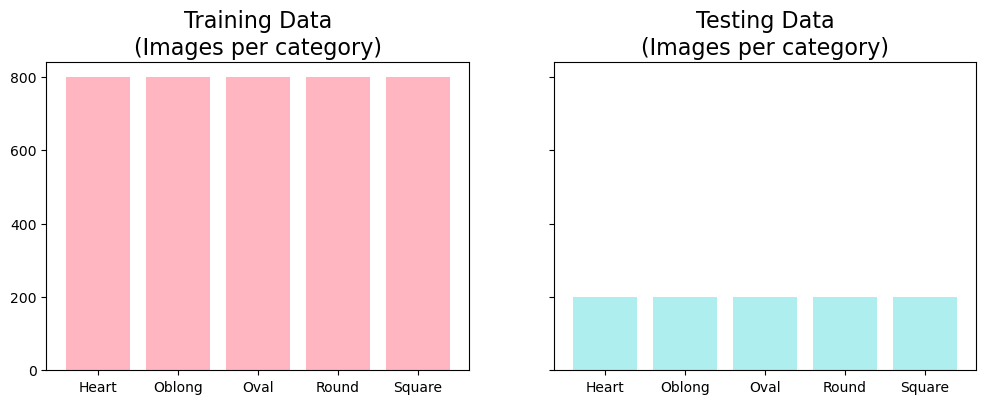

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Direktori dan kategori
train_dir = 'C:/Users/whisn/FaceShape Dataset/training_set'
test_dir = 'C:/Users/whisn/FaceShape Dataset/testing_set'
categories = ['Heart','Oblong','Oval','Round','Square']

# Fungsi untuk membaca data gambar dan membuat dataset
def create_data_files(directory, array, categories, resize=(224, 224)):
    '''this function reads the images from the directory and create training & testing datasets'''
    i = 0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the categories
        img_list = os.listdir(path)
        try:
            for img in img_list:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                #melewati gambar yang rusak
                if img_array is None:
                    print(f'Skipping corrupted or unreadable image: {img}')
                    continue  
                if resize is not None:
                    img_array = cv2.resize(img_array, resize)  # Resize image to consistent shape
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
            print(f'Error: \n category: {category}\n image: {img}')
        
        # Print progress every 200 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list) * len(categories)}")

# Membaca data pelatihan dan pengujian
training_data = []
testing_data = []

create_data_files(train_dir, training_data, categories)
create_data_files(test_dir, testing_data, categories)

# Mengonversi data menjadi numpy array
images_train = np.asarray([x[0] for x in training_data])
labels_train = np.asarray([x[1] for x in training_data])

images_test = np.asarray([x[0] for x in testing_data])
labels_test = np.asarray([x[1] for x in testing_data])

# Menampilkan bentuk data
print(f'Training images shape: {images_train.shape}, Training labels shape: {labels_train.shape}')
print(f'Testing images shape: {images_test.shape}, Testing labels shape: {labels_test.shape}')

# Menghitung jumlah gambar per kategori
training_labels = np.asarray([x[1] for x in training_data])
testing_labels = np.asarray([x[1] for x in testing_data])

# Plotting distribusi gambar per kategori
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)

# Hitung jumlah gambar per kategori untuk data pelatihan
ax[0].bar(x=categories, height=np.bincount(training_labels), color='lightpink')
ax[0].set_title('Training Data\n(Images per category)', size=16)

# Hitung jumlah gambar per kategori untuk data pengujian
ax[1].bar(x=categories, height=np.bincount(testing_labels), color='paleturquoise')
ax[1].set_title('Testing Data\n(Images per category)', size=16)

# Menyesuaikan ticks pada sumbu y
ax[1].set_yticks(range(0, 801, 200))

plt.show()


In [30]:
# Menampilkan ringkasan untuk dataset pelatihan dan pengujian
print_summary(training_data, testing_data)


Training Dataset:
Shape: (3999, 224, 224)
Classes: [0 1 2 3 4]
No. of Images in each class: [800 799 800 800 800]
Max Pixels: 255

--------------------------------------

Testing Dataset:
Shape: (1000, 224, 224)
Classes: [0 1 2 3 4]
No. of Images in each class: [200 200 200 200 200]
Max Pixels: 255

--------------------------------------


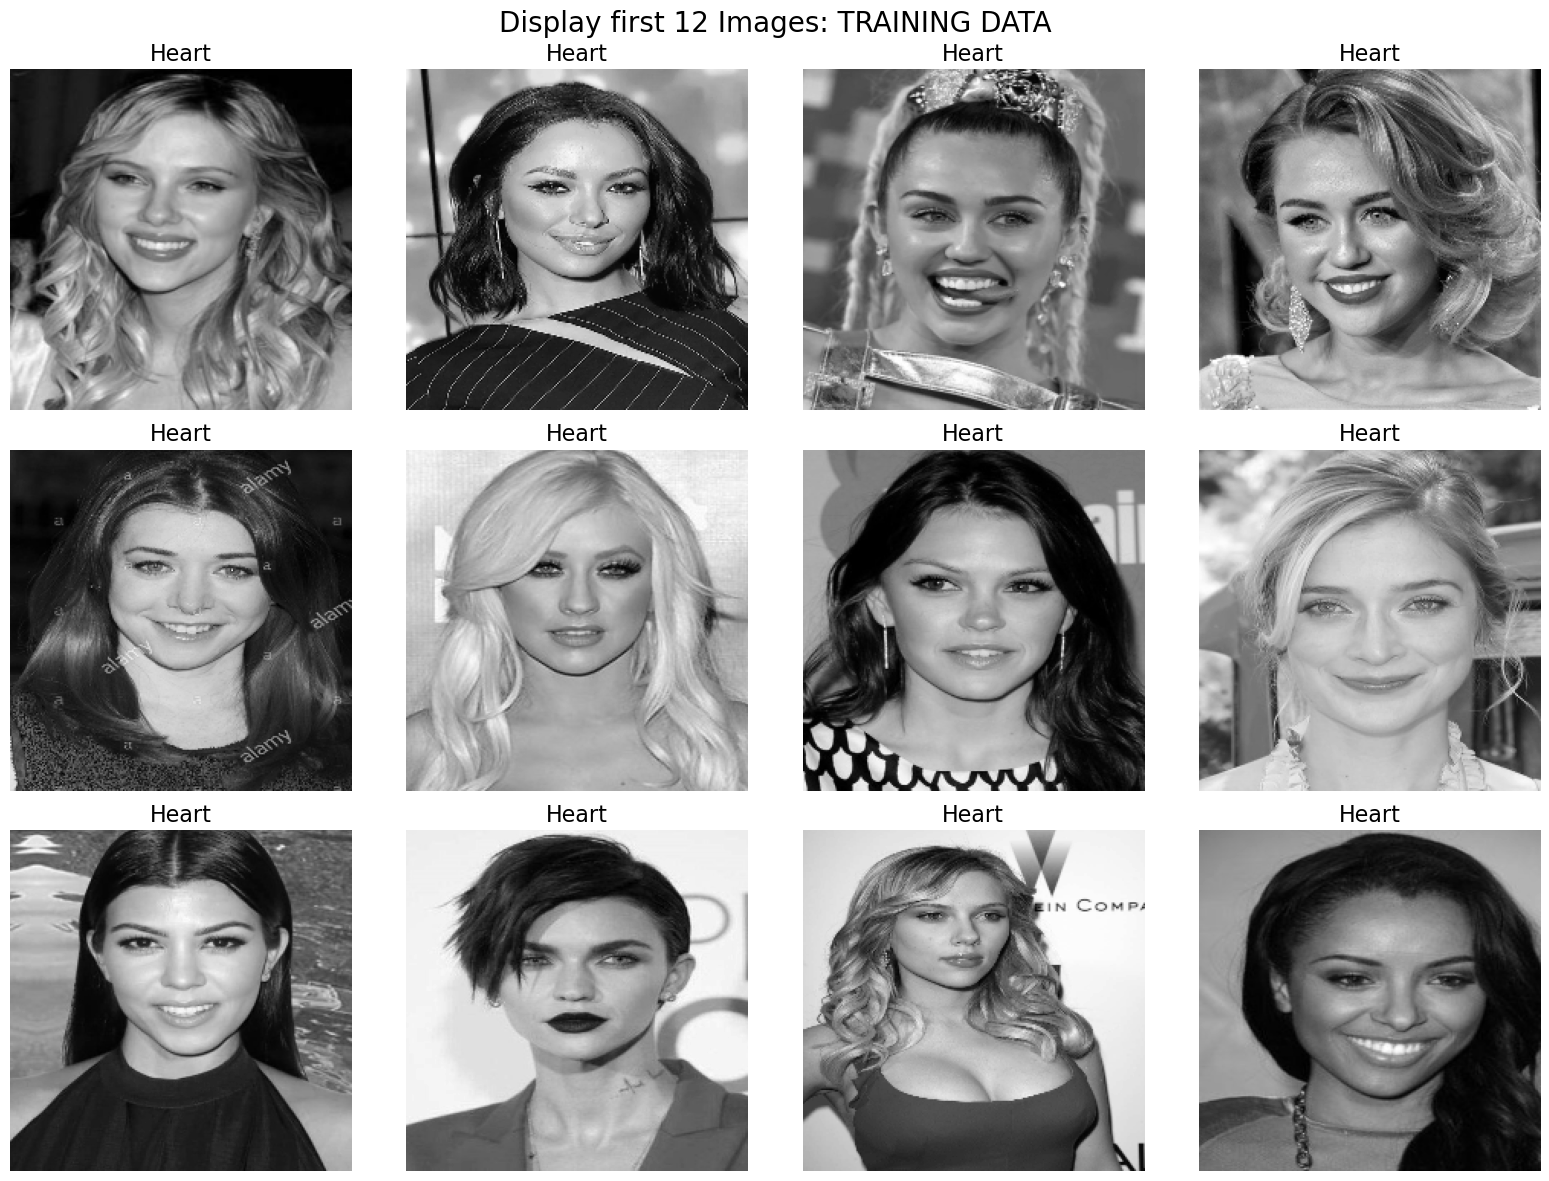

In [39]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', ncols=4)

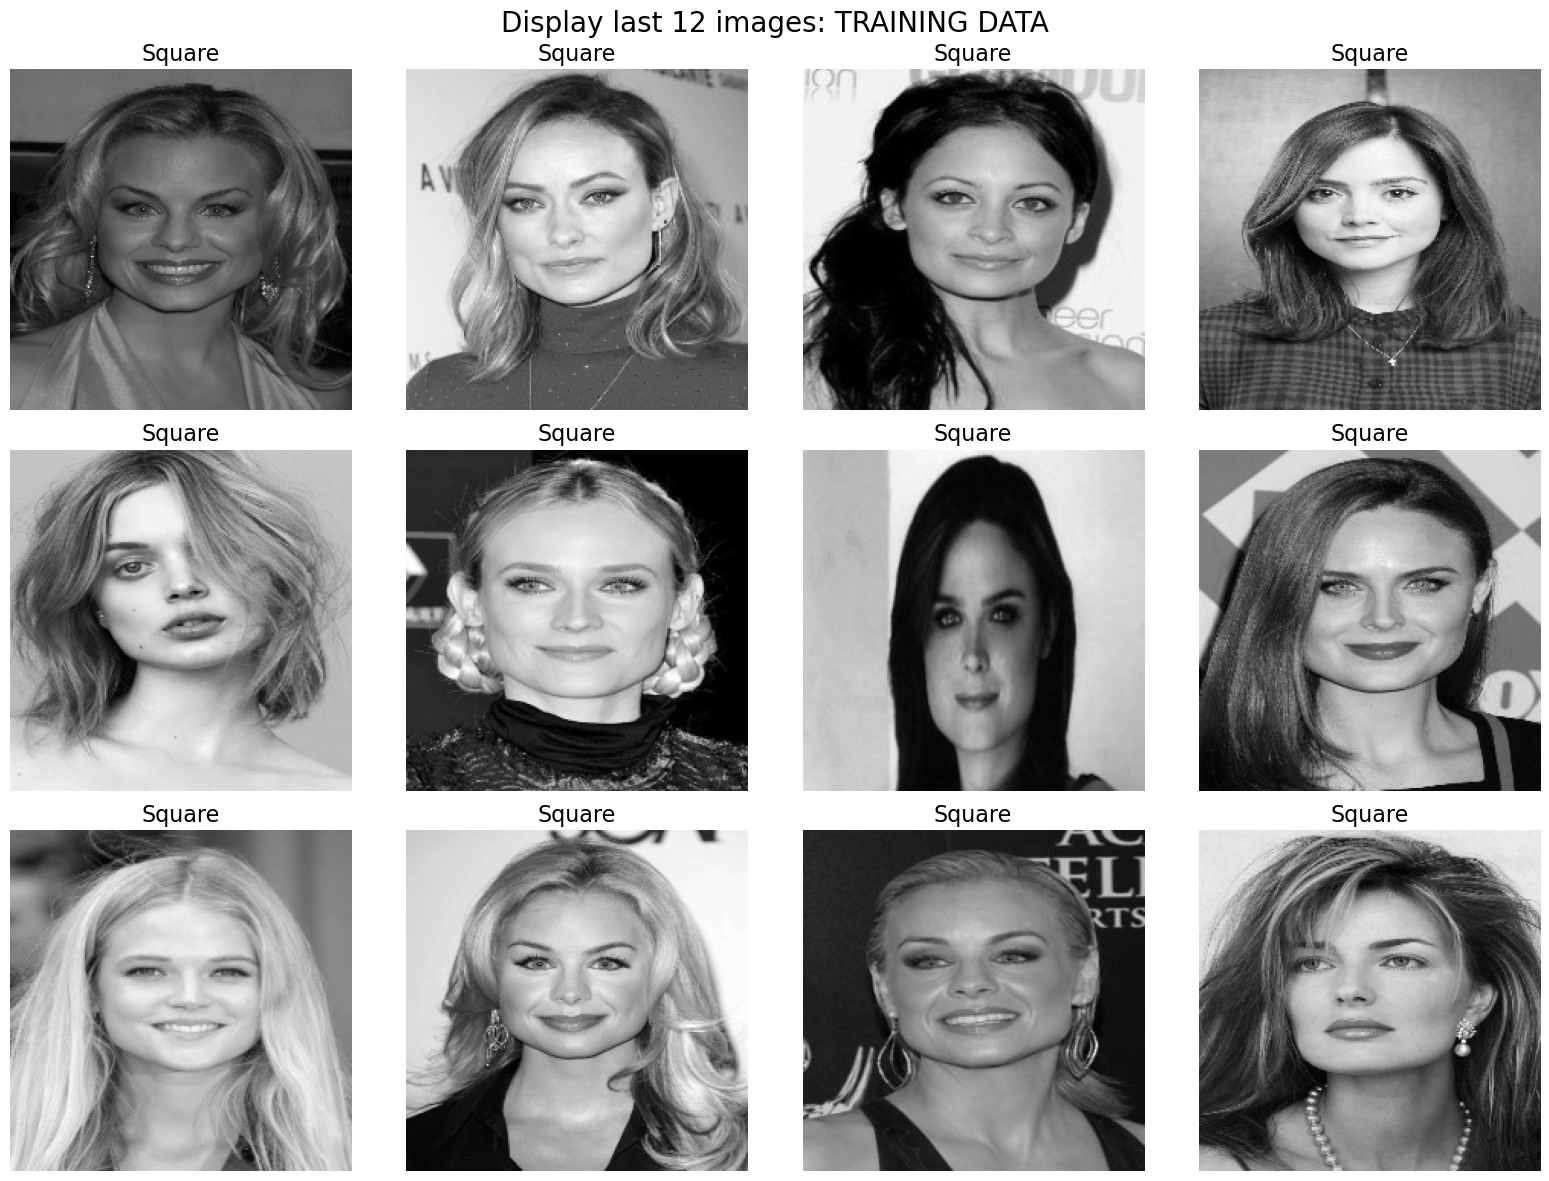

In [33]:
show_img(12, training_data[len(training_data)-12:], 'Display last 12 images: TRAINING DATA', ncols=4)

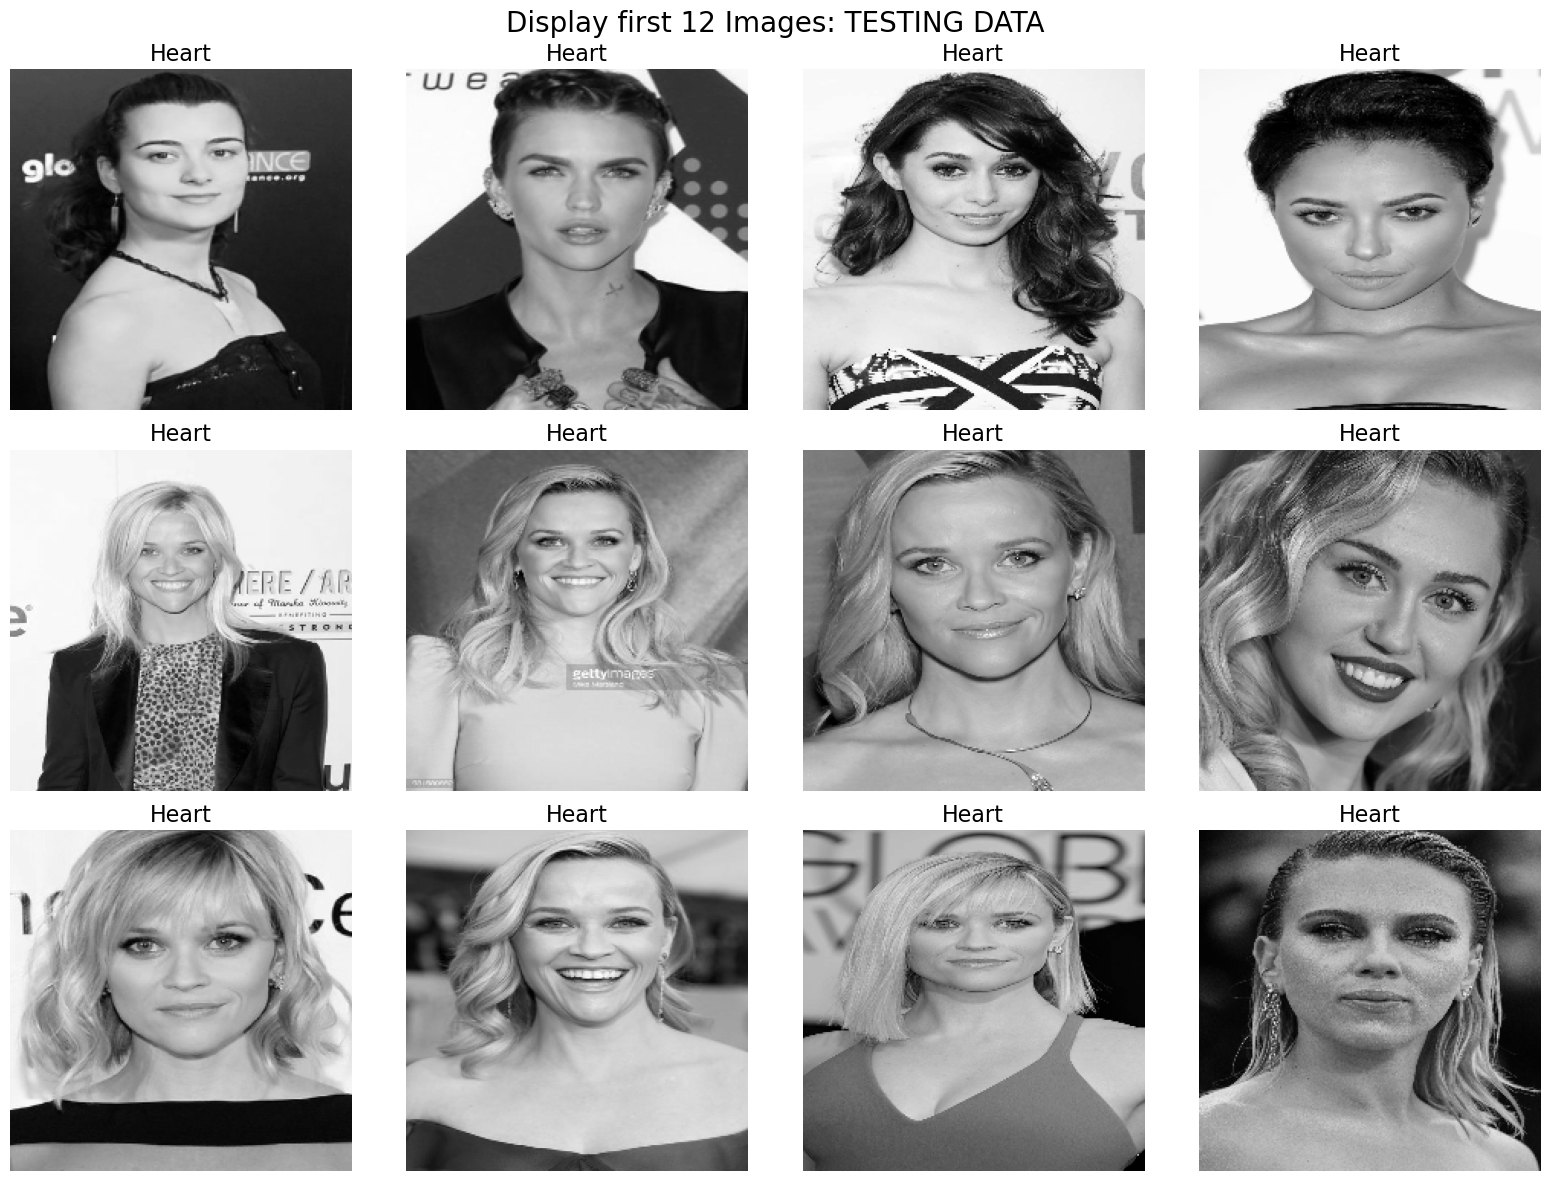

In [40]:
show_img(12, testing_data[:12], 'Display first 12 Images: TESTING DATA', ncols=4)

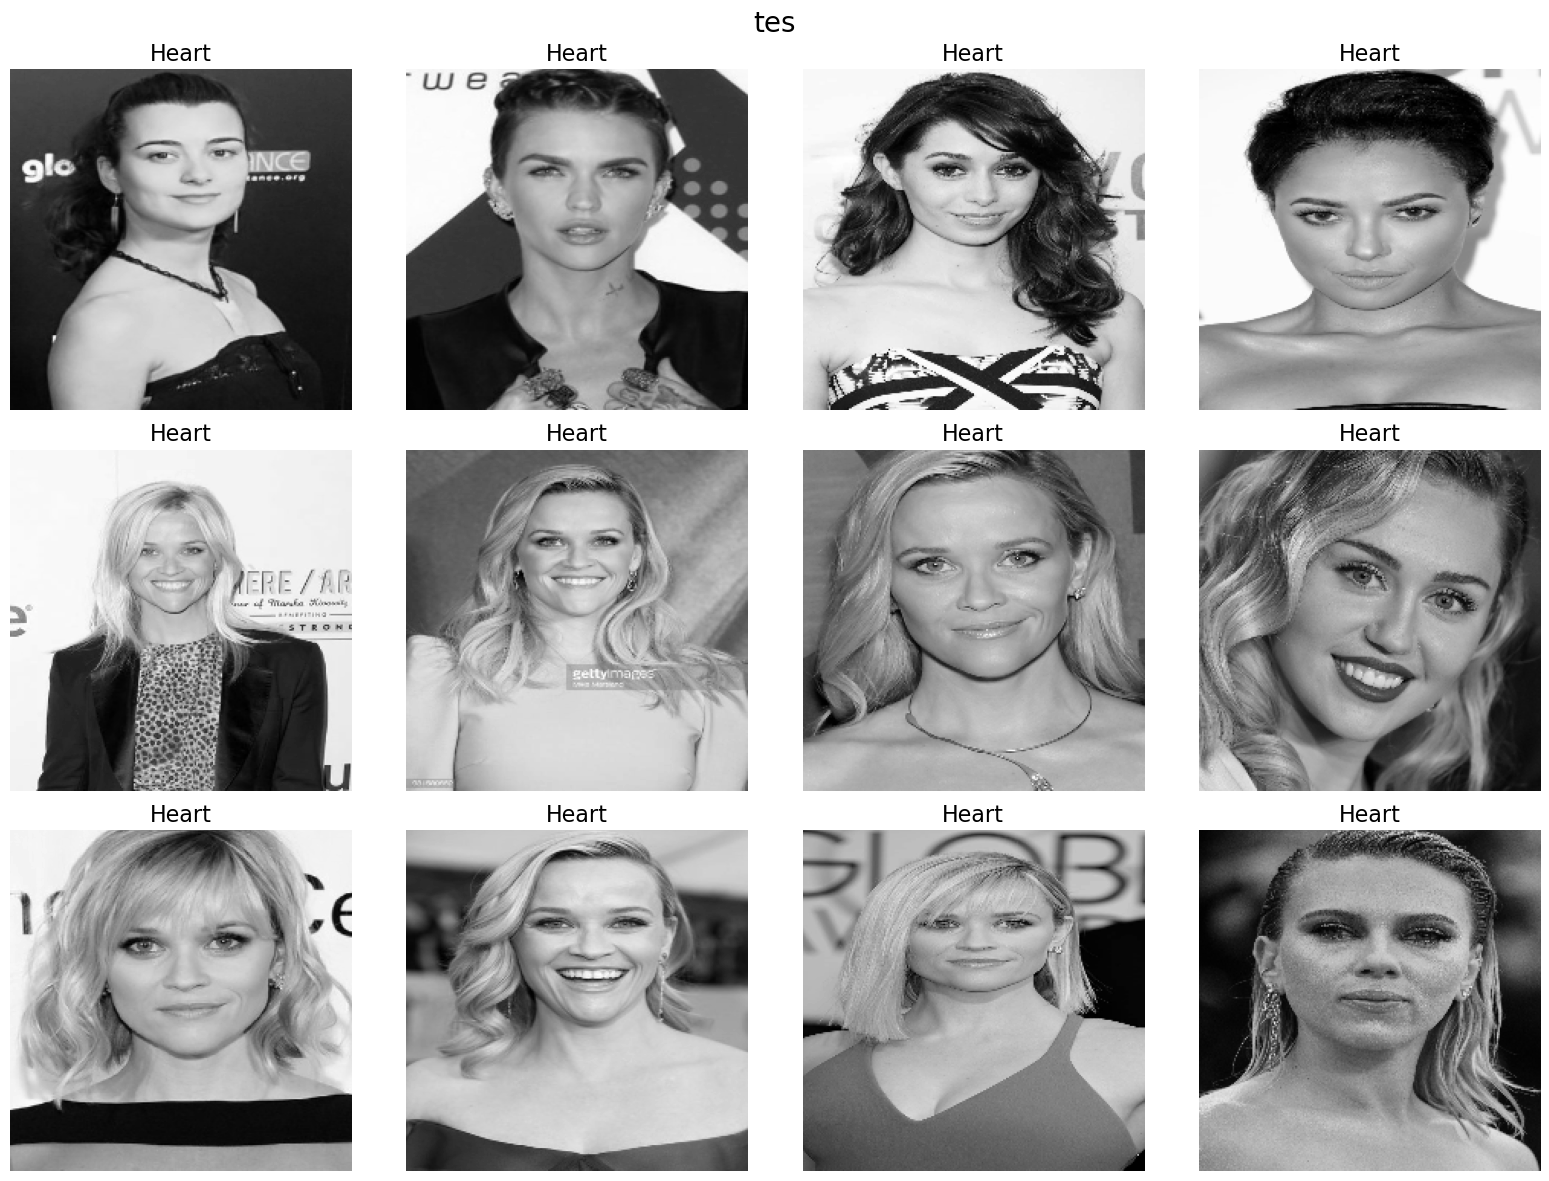

In [51]:
show_img(12, testing_data[:20], 'tes', ncols=4)

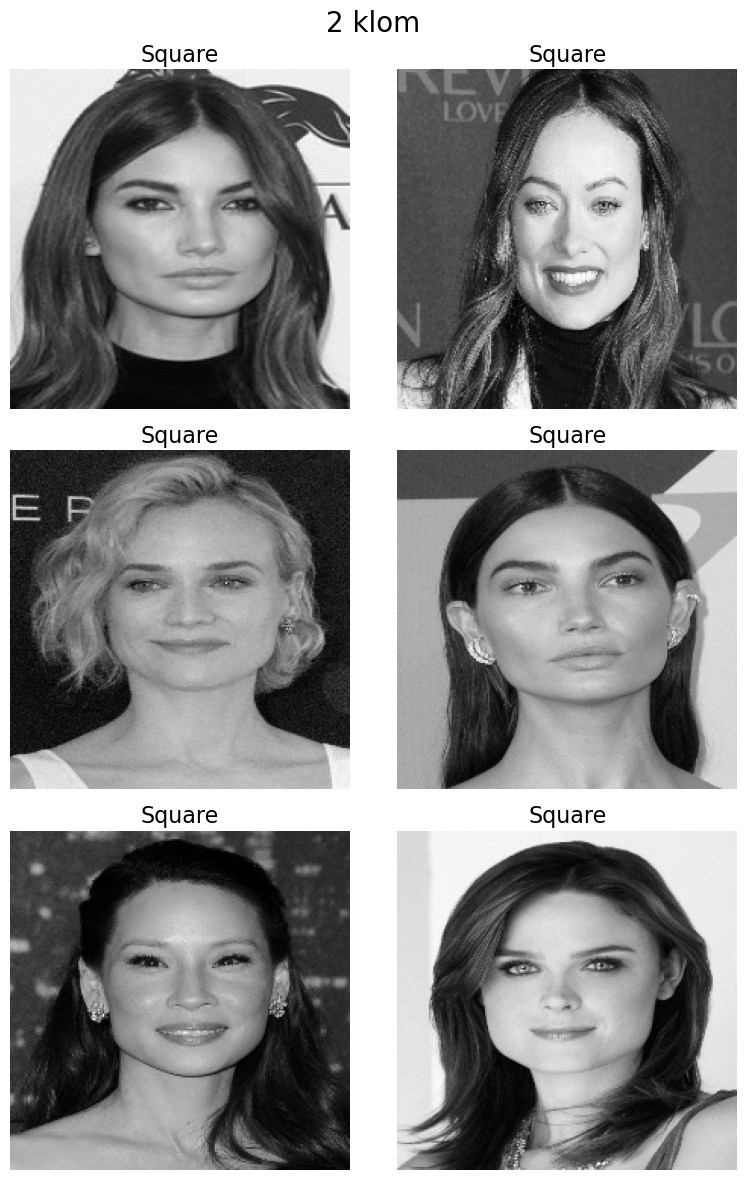

In [46]:
show_img(6, training_data[len(training_data)-20:], '2 klom', ncols=2)